# Exploratory Data Analysis

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from glob import glob

import noisereduce as nr

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import librosa
import librosa.display
import IPython.display as ipd

from itertools import cycle
sns.set_theme(style="white", palette=None)
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
color_cycle = cycle(plt.rcParams["axes.prop_cycle"].by_key()["color"])

In [2]:
def get_max_frequency(file_path):
    """Get max frequency of a .wav file"""
    y, sr = librosa.load(file_path, sr=None)
    # Compute the short-time Fourier transform
    D = np.abs(librosa.stft(y))
    # Compute the frequency range
    freqs = librosa.fft_frequencies(sr=160000) # Hardcoded frequency
    # Compute the average power spectral density
    avg_psd = np.mean(librosa.amplitude_to_db(D, ref=np.max), axis=1)
    # Find the frequency with the maximum power spectral density
    max_freq = freqs[np.argmax(avg_psd)]
    return max_freq

def calculate_average(frequency: float):
    # Calculate the average of the highest frequencies
    avg_max_freq = np.mean(frequency)
    print(f"Average highest frequency: {avg_max_freq} Hz")

    # Suggest a sample rate (double the average highest frequency, rounded up to nearest standard rate)
    suggested_sample_rate = int(np.ceil(avg_max_freq * 2 / 1000) * 1000)
    print(f"Suggested sample rate: {suggested_sample_rate} Hz")


## Local file path

### Only use 6db sample
* Experiment with using 0db or -6dB samples as we do not have baseline background noise

In [3]:

# audio_files = glob('/Users/jaimacabangon/Downloads/slider_0db/*/*/*.wav')
audio_files = glob('/Users/jaimacabangon/Downloads/slider_-6db/*/*/*.wav')
# audio_files = glob('/Users/jaimacabangon/Downloads/slider_6db/*/*/*.wav')
# audio_files_fan_0 = glob('/Users/jaimacabangon/Downloads/fan_0db/*/*/*.wav')
audio_files_fan_minus_6 = glob('/Users/jaimacabangon/Downloads/fan_-6db/*/*/*.wav')
# audio_files_fan_6 = glob('/Users/jaimacabangon/Downloads/fan_6db/*/*/*.wav')
# audio_files_pump_0 = glob('/Users/jaimacabangon/Downloads/pump_0db/*/*/*.wav')
audio_files_pump_minus_6 = glob('/Users/jaimacabangon/Downloads/pump_-6db/*/*/*.wav')
# audio_files_pump_6 = glob('/Users/jaimacabangon/Downloads/pump_6db/*/*/*.wav')
# audio_files_valve_0 = glob('/Users/jaimacabangon/Downloads/valve_0db/*/*/*.wav')
audio_files_valve_minus_6 = glob('/Users/jaimacabangon/Downloads/valve_-6db/*/*/*.wav')
# audio_files_valve_6 = glob('/Users/jaimacabangon/Downloads/valve_6db/*/*/*.wav')


# audio_files.extend(audio_files_6)
# audio_files.extend(audio_files_minus_6)


# audio_files.extend(audio_files_fan_0)
# audio_files.extend(audio_files_fan_minus_6)
audio_files.extend(audio_files_fan_minus_6)

# audio_files.extend(audio_files_pump_0)
# audio_files.extend(audio_files_pump_minus_6)
audio_files.extend(audio_files_pump_minus_6)

# audio_files.extend(audio_files_valve_0)
# audio_files.extend(audio_files_valve_minus_6)
audio_files.extend(audio_files_valve_minus_6)


In [4]:
print(len(audio_files), audio_files[0])

18019 /Users/jaimacabangon/Downloads/slider_-6db/id_00/abnormal/00000059.wav


In [5]:
# Abnormal sound
ipd.Audio(audio_files[0])

#### Y = Raw Value
#### Sample Rate 16khz 

In [6]:
y, sample_rate = librosa.load(audio_files[0], sr=None)
print(f'Raw data (10): {y[:10]}')
print(f'Raw data shape: {y.shape}')
print(f'Sample Rate: {sample_rate}')

Raw data (10): [0.0153389  0.01615524 0.01452255 0.01093674 0.00948334 0.00923538
 0.00807953 0.00635147 0.00376511 0.00335312]
Raw data shape: (160000,)
Sample Rate: 16000


### Raw Audio sample (No Fourier Transform)

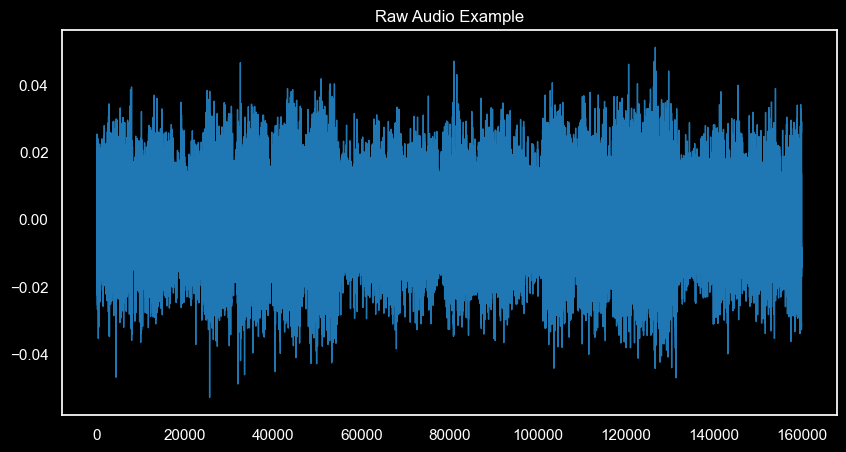

In [7]:
plt.style.use('dark_background')

pd.Series(y).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Example',
                 color=color_pal[0])
plt.show()

# Spectrogram sample
* Generate a mel one

# Spectrogram sample
* log spectogram 

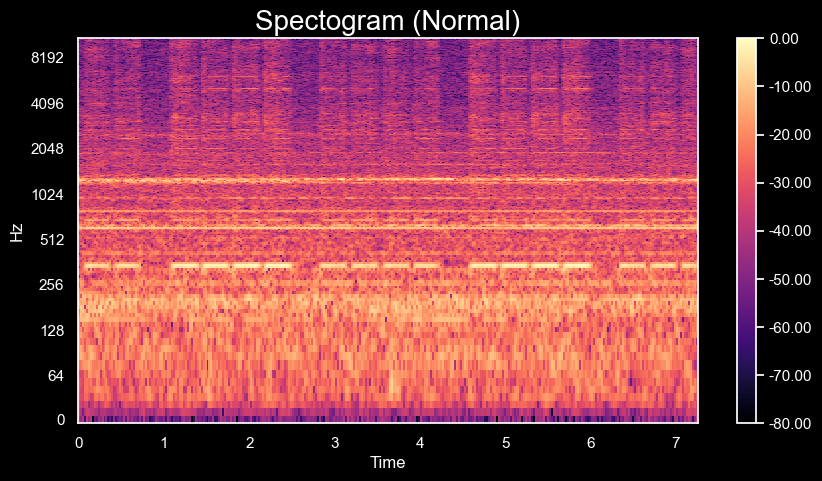

In [8]:
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

# Plot the transformed audio data
fig, ax = plt.subplots(figsize=(10, 5))
img = librosa.display.specshow(S_db,
                              x_axis='time',
                              y_axis='log',
                              ax=ax)
ax.set_title('Spectogram (Normal)', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

### Zoomed in view 100000 <-> 150000

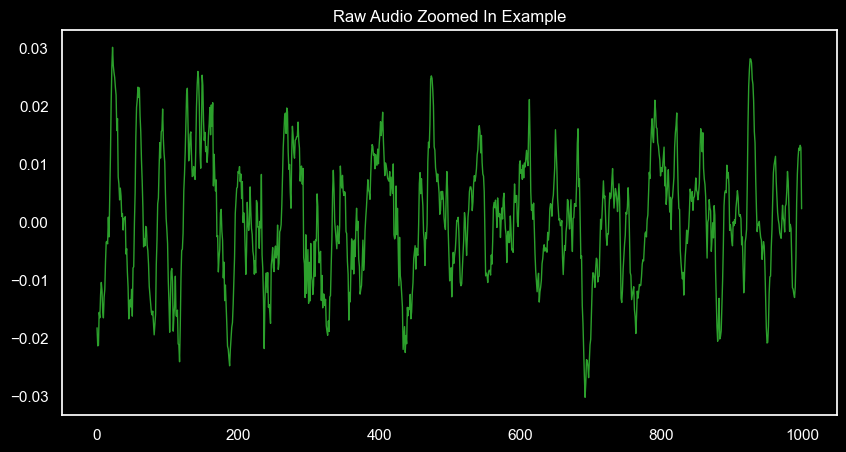

In [9]:
plt.style.use('dark_background')


pd.Series(y[149000:150000]).plot(figsize=(10, 5),
                  lw=1,
                  title='Raw Audio Zoomed In Example',
                 color=color_pal[2])
plt.show()

# Create initial Dataframe
* Split string for data frame creation
* Initial dataframe will include:
    * Machine type (slider, valve, fan, pump)
    * unique machine ID (id_NN)
    * wav file name
    * Sound type (normal vs abnormal)
    * Raw data (raw audio data)

In [10]:
test = audio_files[0]
new = test.split('/')
print(new)

['', 'Users', 'jaimacabangon', 'Downloads', 'slider_-6db', 'id_00', 'abnormal', '00000059.wav']


In [11]:
raw_data_list = [] 
sample_rate_list = []
sound_source_list = [] 
binary_classification_list = [] 
wav_file_list = [] 
name_classification_list = []

for audio_file in audio_files:
    split_string = str(audio_file).split('/')
    sound_source = split_string[4]
    name_classification = sound_source.split("_")[0]
    binary_classification = split_string[6]
    wav_file = split_string[7]
    raw_data, sample_rate = librosa.load(audio_file, sr=None)
    sound_source_list.append(sound_source)
    binary_classification_list.append(binary_classification)
    wav_file_list.append(wav_file)
    raw_data_list.append(raw_data)
    sample_rate_list.append(sample_rate)
    name_classification_list.append(name_classification)


    

### 50k samples average time to DF ~5mins

In [12]:
df = pd.DataFrame(columns=["Sound Source","Machine Type", "Classification", ".wav File", "Sample Rate", "Raw Data"])

In [13]:
df["Sound Source"] = sound_source_list
df["Machine Type"] = name_classification_list # label for machine type 
df["Classification"] = binary_classification_list # label for 0 or 1 (normal vs abnormal)
df[".wav File"] = wav_file_list
df["Sample Rate"] = sample_rate_list
df["Raw Data"] = raw_data_list

In [14]:
df

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0      slider_-6db       slider       abnormal  00000059.wav        16000   
1      slider_-6db       slider       abnormal  00000071.wav        16000   
2      slider_-6db       slider       abnormal  00000065.wav        16000   
3      slider_-6db       slider       abnormal  00000273.wav        16000   
4      slider_-6db       slider       abnormal  00000267.wav        16000   
...            ...          ...            ...           ...          ...   
18014   valve_-6db        valve         normal  00000083.wav        16000   
18015   valve_-6db        valve         normal  00000097.wav        16000   
18016   valve_-6db        valve         normal  00000068.wav        16000   
18017   valve_-6db        valve         normal  00000040.wav        16000   
18018   valve_-6db        valve         normal  00000054.wav        16000   

                                                Raw Data  
0      [0.015338898, 0.016155243, 0.0145225525, 0.010...  
1      [-0.008609772, -0.0060157776, -0.0033226013, 0...  
2      [-0.0046806335, -0.0030708313, -0.0011520386, ...  
3      [-0.007293701, -0.0055770874, -0.0047302246, 0...  
4      [0.0113220215, 0.012916565, 0.014007568, 0.014...  
...                                                  ...  
18014  [-0.006477356, -0.0058250427, -0.006668091, -0...  
18015  [0.017017365, 0.01581955, 0.01424408, 0.012397...  
18016  [-0.004886627, -0.002986908, -0.0011634827, -0...  
18017  [-0.003944397, -0.0062942505, -0.009212494, -0...  
18018  [0.0069274902, 0.0069274902, 0.006252289, 0.00...  

[18019 rows x 6 columns]

# Calculate mean/std of raw audio data 

In [15]:
df['Mean'] = df['Raw Data'].apply(np.mean)
df['Standard Deviation'] = df['Raw Data'].apply(np.std)
# df['Max Value'] = df['Raw Data'].apply(np.max)
# df['Min Value'] = df['Raw Data'].apply(np.min) # comment out to reduce time

In [16]:
print(df["Classification"].value_counts(), "\n")
print(f'Raw data shape: {y.shape}')
df["Sound Source"].value_counts()

Classification
normal      14719
abnormal     3300
Name: count, dtype: int64 

Raw data shape: (160000,)


Sound Source
fan_-6db       5550
pump_-6db      4205
valve_-6db     4170
slider_-6db    4094
Name: count, dtype: int64

Audio distribution
* normal    ->  44157
* abnormal   -> 9900

### Data taken at consistent sample rate of 16khz
### Abnormal vs normal samples are not 50:50
#### Normal % = 81.7% 
#### Abnormal % =18.3%


### Given Sample rate is consistent, reducing sample rate is not recommended as we could lose audio quality. 

In [17]:
df["Classification"] == "abnormal"

0         True
1         True
2         True
3         True
4         True
         ...  
18014    False
18015    False
18016    False
18017    False
18018    False
Name: Classification, Length: 18019, dtype: bool

# Normal vs Markdown visualizations

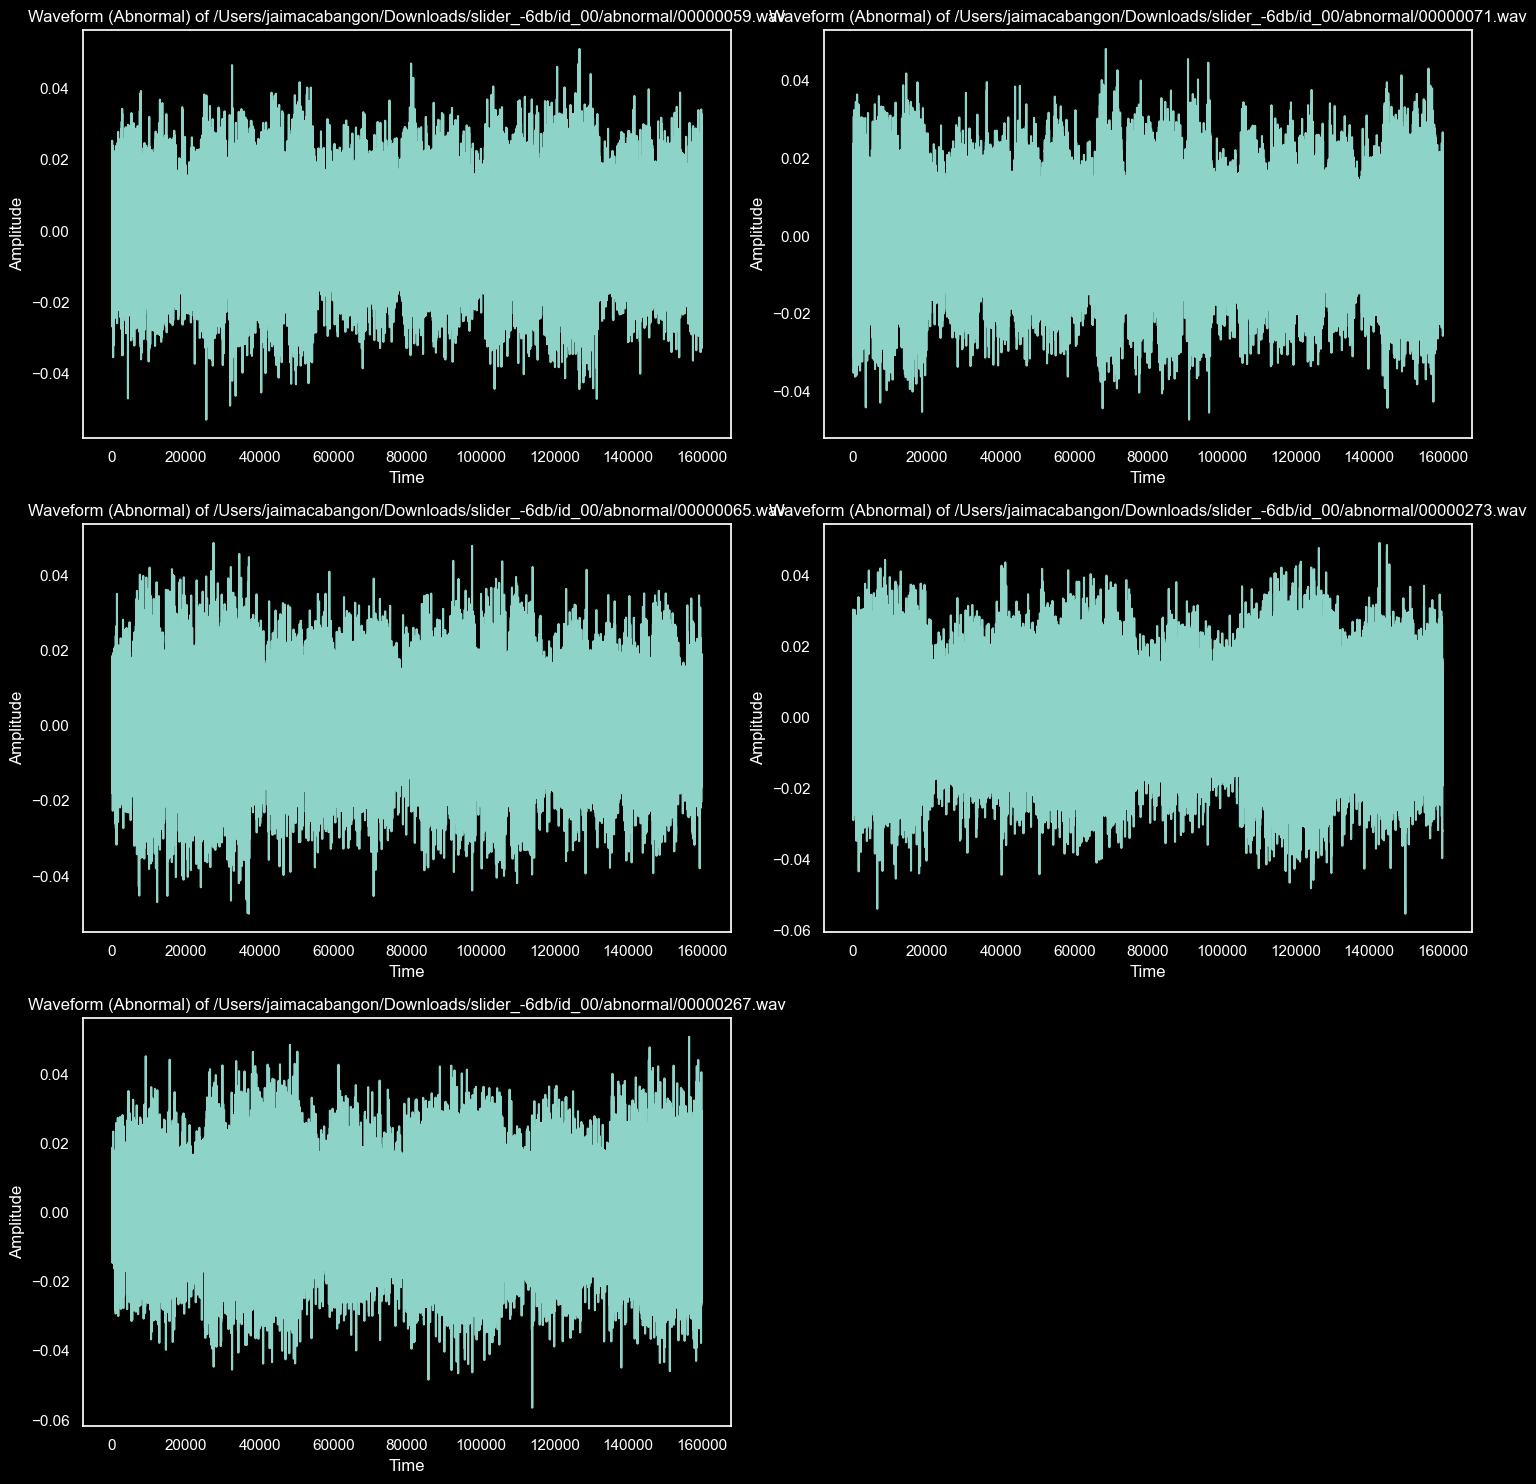

In [18]:
# Number of audio files
num_files = len(audio_files[0:5])

# Calculate the number of rows and columns for subplots
rows = (num_files + 1) // 2
cols = 2

plt.style.use('dark_background')

# Create a figure with the appropriate number of subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axs array for easier iteration
axs = axs.flatten()

# Iterate over the audio files and plot each one
for i, file in enumerate(audio_files[0:5]):
    # Load the audio file
    y, sample_rate = librosa.load(file, sr=None)
    
    # Plot the waveform
    axs[i].plot(y)
    axs[i].set_title(f'Waveform (Abnormal) of {file}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

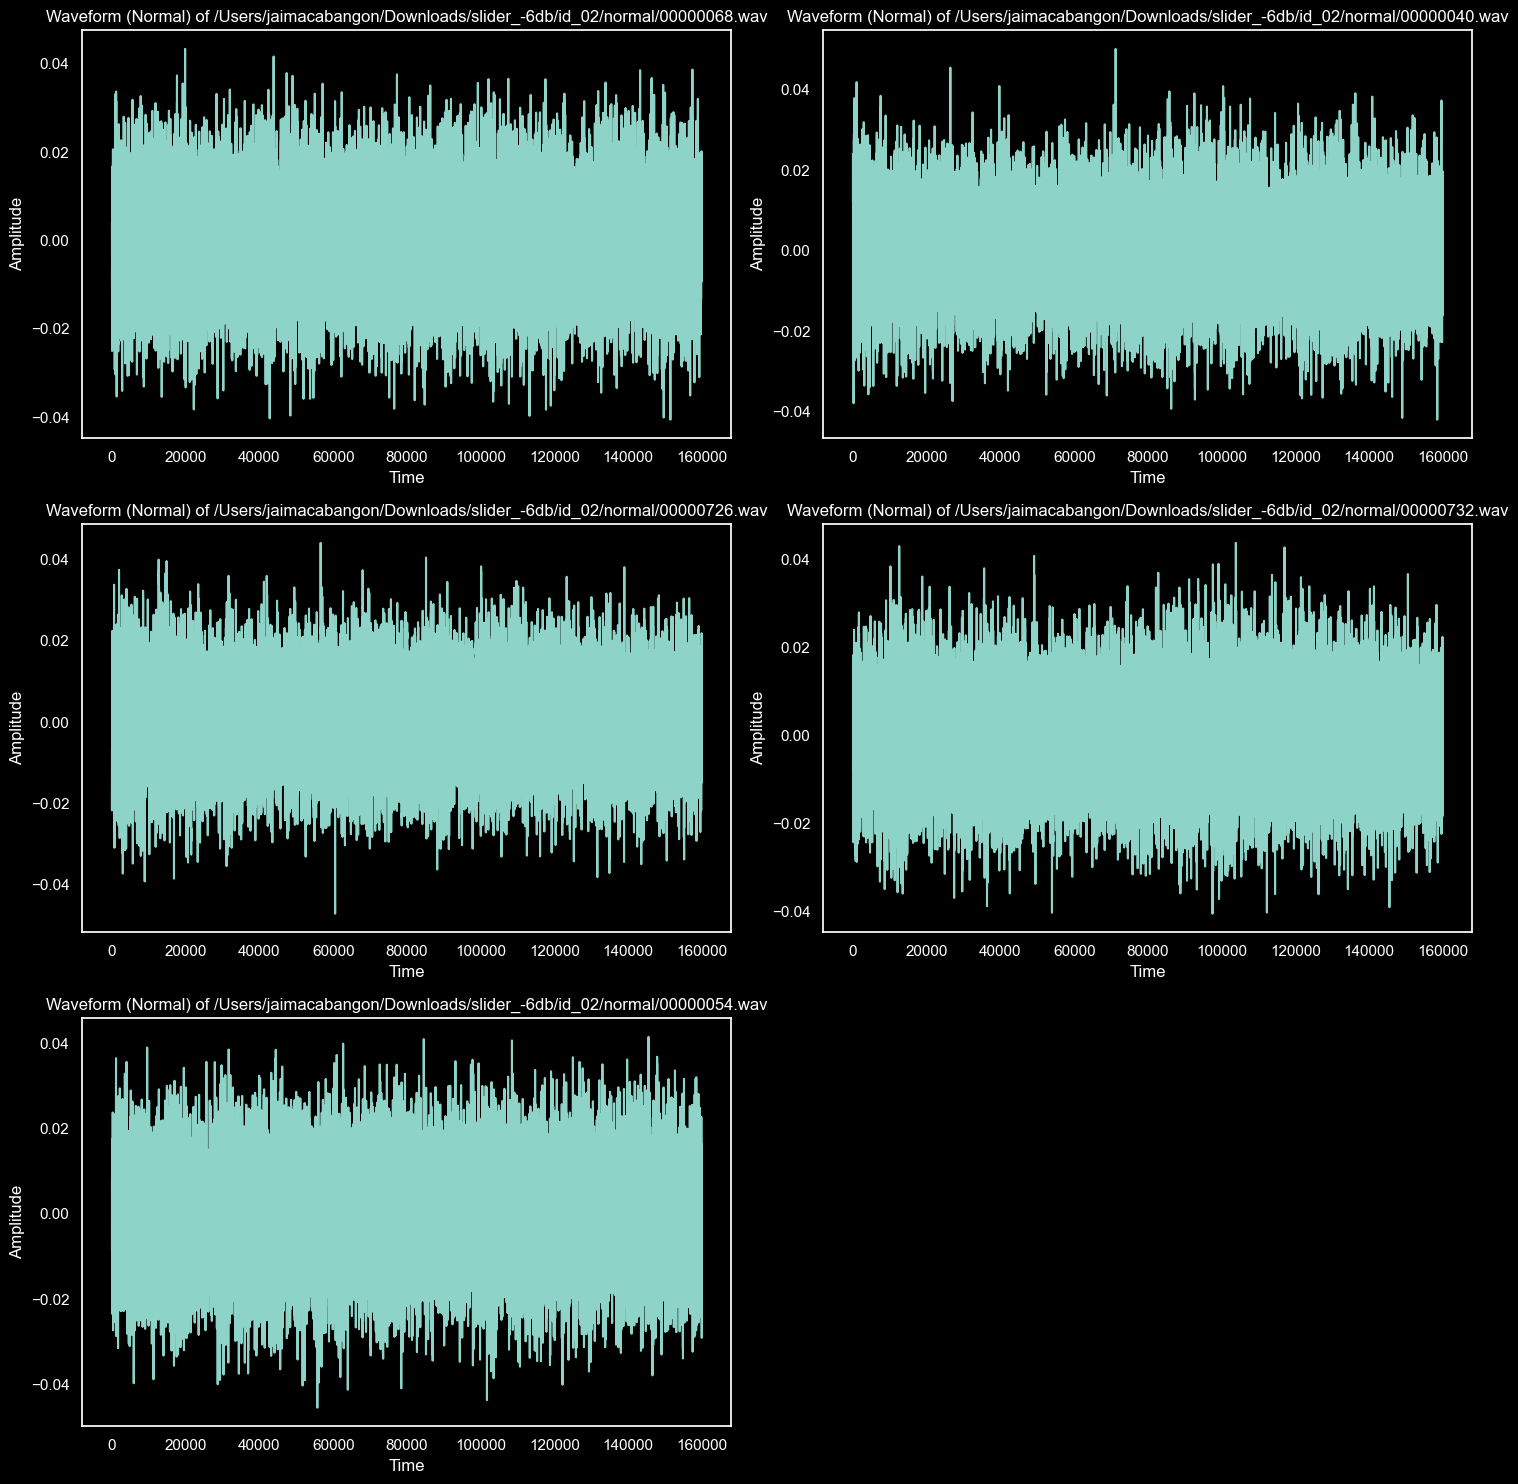

In [19]:
# Number of audio files
num_files = len(audio_files[4089:4094])

# Calculate the number of rows and columns for subplots
rows = (num_files + 1) // 2
cols = 2

# Create a figure with the appropriate number of subplots
fig, axs = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Flatten the axs array for easier iteration
axs = axs.flatten()
plt.style.use('dark_background')


# Iterate over the audio files and plot each one
for i, file in enumerate(audio_files[4089:4094]):
    # Load the audio file
    y, sample_rate = librosa.load(file, sr=None)
    
    # Plot the waveform
    axs[i].plot(y)
    axs[i].set_title(f'Waveform (Normal) of {file}')
    axs[i].set_xlabel('Time')
    axs[i].set_ylabel('Amplitude')

# Hide any empty subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the figure
plt.show()

# RMS AND ZCR Calculations

In [20]:
def calculate_rms(signal):
    """Calculate RMS power of the signal."""
    return np.sqrt(np.mean(np.square(signal)))

def calculate_zero_crossing_rate(signal):
    """Calculate zero-crossing rate of the signal."""
    return np.mean(librosa.zero_crossings(signal, pad=False))

In [21]:
df.head()

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0  slider_-6db       slider       abnormal  00000059.wav        16000   
1  slider_-6db       slider       abnormal  00000071.wav        16000   
2  slider_-6db       slider       abnormal  00000065.wav        16000   
3  slider_-6db       slider       abnormal  00000273.wav        16000   
4  slider_-6db       slider       abnormal  00000267.wav        16000   

                                            Raw Data          Mean  \
0  [0.015338898, 0.016155243, 0.0145225525, 0.010... -1.413584e-07   
1  [-0.008609772, -0.0060157776, -0.0033226013, 0... -1.954079e-06   
2  [-0.0046806335, -0.0030708313, -0.0011520386, ... -9.454727e-07   
3  [-0.007293701, -0.0055770874, -0.0047302246, 0... -4.518628e-06   
4  [0.0113220215, 0.012916565, 0.014007568, 0.014...  1.510930e-06   

   Standard Deviation  
0            0.011189  
1            0.010632  
2            0.011289  
3            0.011458  
4            0.011950

In [22]:
df["RMS"] = df["Raw Data"].apply(calculate_rms)
# df["ZCR"] = df["Raw Data"].apply(calculate_zero_crossing_rate)

# Total distribution of RMS/ZCR calculation 

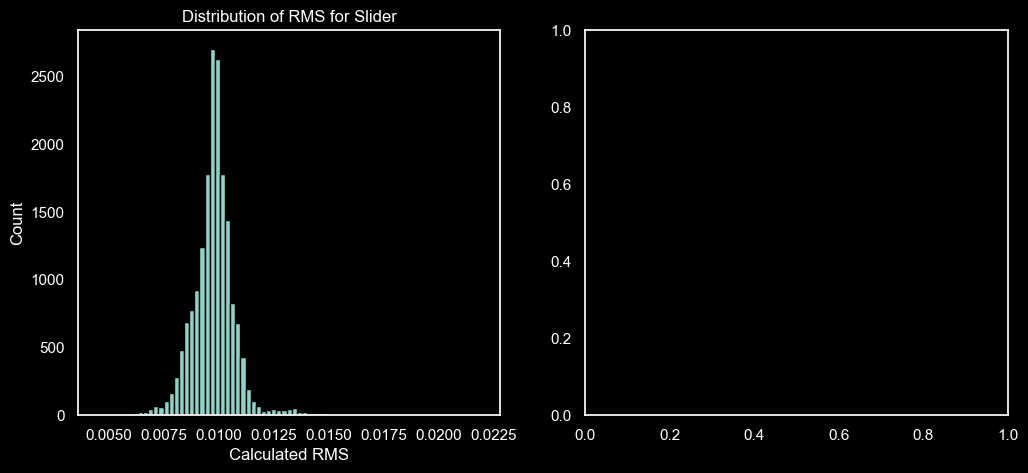

In [23]:
# Create a histogram with matplotlib
# plt.hist(df['RMS'], bins=75, edgecolor='black')
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
plt.style.use('dark_background')

# # # Customize the plot
# # plt.xlabel('RMS')
# # plt.ylabel('Count')
# plt.title('Distribution of RMS for 0db Slider')

axs[0].hist(df['RMS'], bins=75, edgecolor='black')
axs[0].set_title('Distribution of RMS for Slider')
axs[0].set_xlabel('Calculated RMS')
axs[0].set_ylabel('Count')

# Histogram for column2
# axs[1].hist(df['ZCR'], bins=75, edgecolor='black')
# axs[1].set_title('Distribution of ZCR for Slider')
# axs[1].set_xlabel('Calculated ZCR')
# axs[1].set_ylabel('Count')


# Show the plot
plt.show()

### Breakdown Dataset 
* Used to visually see distribution of dataset

In [24]:
# slider_0db     4094
# slider_-6db    4094

normal_classification = df['Classification'] == 'normal'
abnormal_classification = df['Classification'] == 'abnormal'

# source_0_db = df['Sound Source'] == 'slider_0db'
# source_minus_6_db = df['Sound Source'] == 'slider_-6db'
source_6_db = df['Sound Source'] == 'slider_6db'


# # 0dB filter
# normal_filtered_df_0_db = df[normal_classification & source_0_db]
# abnormal_filtered_df_0_db = df[abnormal_classification & source_0_db]

# # -6dB filter
# normal_filtered_df_minus_6_db = df[normal_classification & source_minus_6_db]
# abnormal_filtered_df_minus_6_db = df[abnormal_classification & source_minus_6_db]


# 6dB filter
normal_filtered_df_6_db = df[normal_classification & source_6_db]
abnormal_filtered_df_6_db = df[abnormal_classification & source_6_db]

# Normal sound RMS/ZCR distribution
## Indicates lower calculated RMS values most of the samples are around the .0050 -> .0060
### Have to be careful 

# Normal sound distribution (-6dB,0dB)

In [25]:
# fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# plt.style.use('dark_background')


# axs[0,0].hist(normal_filtered_df_minus_6_db['RMS'], bins=50, edgecolor='black')
# axs[0,0].set_title('Distribution of RMS (Normal Sound) for -6dB Slider')
# axs[0,0].set_xlabel('Calculated RMS')
# axs[0,0].set_ylabel('Count')


# axs[0,1].hist(normal_filtered_df_0_db['RMS'], bins=50, edgecolor='black')
# axs[0,1].set_title('Distribution of RMS (Normal Sound) for 0dB Slider')
# axs[0,1].set_xlabel('Calculated RMS')
# axs[0,1].set_ylabel('Count')

# axs[0,2].hist(normal_filtered_df_6_db['RMS'], bins=50, edgecolor='black')
# axs[0,2].set_title('Distribution of RMS (Normal Sound) for 6dB Slider')
# axs[0,2].set_xlabel('Calculated RMS')
# axs[0,2].set_ylabel('Count')


# # Histogram for column2
# axs[1,0].hist(normal_filtered_df_minus_6_db['ZCR'], bins=50, edgecolor='black')
# axs[1,0].set_title('Distribution of ZCR (Normal Sound) for -6db Slider')
# axs[1,0].set_xlabel('Calculated ZCR')
# axs[1,0].set_ylabel('Count')


# # Histogram for column2
# axs[1,1].hist(normal_filtered_df_0_db['ZCR'], bins=50, edgecolor='black')
# axs[1,1].set_title('Distribution of ZCR (Normal Sound) for 0dB Slider')
# axs[1,1].set_xlabel('Calculated ZCR')
# axs[1,1].set_ylabel('Count')



# # Histogram for column2
# axs[1,2].hist(normal_filtered_df_6_db['ZCR'], bins=50, edgecolor='black')
# axs[1,2].set_title('Distribution of ZCR (Normal Sound) for -6db Slider')
# axs[1,2].set_xlabel('Calculated ZCR')
# axs[1,2].set_ylabel('Count')



# # Show the plot
# plt.show()

In [26]:
# normal_filtered_df_0_db.describe()

In [27]:
# normal_filtered_df_minus_6_db.describe()

In [28]:
normal_filtered_df_6_db.describe()

Sample Rate  Mean  Standard Deviation  RMS
count          0.0   0.0                 0.0  0.0
mean           NaN   NaN                 NaN  NaN
std            NaN   NaN                 NaN  NaN
min            NaN   NaN                 NaN  NaN
25%            NaN   NaN                 NaN  NaN
50%            NaN   NaN                 NaN  NaN
75%            NaN   NaN                 NaN  NaN
max            NaN   NaN                 NaN  NaN

# Abnormal sound RMS/ZCR distribution

In [29]:
# fig, axs = plt.subplots(2, 3, figsize=(20, 12))

# plt.style.use('dark_background')

# axs[0,0].hist(abnormal_filtered_df_minus_6_db['RMS'], bins=50, edgecolor='black')
# axs[0,0].set_title('Distribution of RMS (Abnormal Sound) for -6dB Slider')
# axs[0,0].set_xlabel('Calculated RMS')
# axs[0,0].set_ylabel('Count')

# axs[0,1].hist(abnormal_filtered_df_0_db['RMS'], bins=50, edgecolor='black')
# axs[0,1].set_title('Distribution of RMS (Abnormal Sound) for 0dB Slider')
# axs[0,1].set_xlabel('Calculated RMS')
# axs[0,1].set_ylabel('Count')

# axs[0,2].hist(abnormal_filtered_df_6_db['RMS'], bins=50, edgecolor='black')
# axs[0,2].set_title('Distribution of RMS (Abnormal Sound) for 6dB Slider')
# axs[0,2].set_xlabel('Calculated RMS')
# axs[0,2].set_ylabel('Count')


# axs[1,0].hist(abnormal_filtered_df_minus_6_db['ZCR'], bins=50, edgecolor='black')
# axs[1,0].set_title('Distribution of ZCR (Abnormal Sound) for -6dB Slider')
# axs[1,0].set_xlabel('Calculated ZCR')
# axs[1,0].set_ylabel('Count')


# # Histogram for column2
# axs[1,1].hist(abnormal_filtered_df_0_db['ZCR'], bins=50, edgecolor='black')
# axs[1,1].set_title('Distribution of ZCR (Abnormal Sound) for 0dB Slider')
# axs[1,1].set_xlabel('Calculated ZCR')
# axs[1,1].set_ylabel('Count')


# # Histogram for column2
# axs[1,2].hist(abnormal_filtered_df_6_db['ZCR'], bins=50, edgecolor='black')
# axs[1,2].set_title('Distribution of ZCR (Abnormal Sound) for 6db Slider')
# axs[1,2].set_xlabel('Calculated ZCR')
# axs[1,2].set_ylabel('Count')



# # Show the plot
plt.show()

# ***Something to note is that RMS distribution overall for abnormal sound is higher, which could indicate that those are the abnormal sound signals we want to predict


In [30]:
# abnormal_filtered_df_0_db.describe()

In [31]:
# abnormal_filtered_df_minus_6_db.describe()

In [32]:
abnormal_filtered_df_6_db.describe()

Sample Rate  Mean  Standard Deviation  RMS
count          0.0   0.0                 0.0  0.0
mean           NaN   NaN                 NaN  NaN
std            NaN   NaN                 NaN  NaN
min            NaN   NaN                 NaN  NaN
25%            NaN   NaN                 NaN  NaN
50%            NaN   NaN                 NaN  NaN
75%            NaN   NaN                 NaN  NaN
max            NaN   NaN                 NaN  NaN

# Calculate percentage difference between mean normal RMS/ZCR and mean abnormal RMS/ZCR

$$\text{Percentage Difference} = \left| \frac{\text{abnormal RMS/ZCR} - \text{normal RMS/ZCR}}{\text{normal RMS/ZCR}} \right| \times 100$$



# Results (-6dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.009614 | 0.010491 | 9.1%
| ZCR Mean  |0.064470| 0.076893 | 19.2%

# Results (0dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.005687 | 0.006960 | 22.3%
| ZCR Mean  |0.064451| 0.086448 | 34%


# Results (6dB Slider)

|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.004132| 0.005705| 38.0%
| ZCR Mean  |0.060384| 0.087477 | 44.86%







In [33]:
df.head()

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0  slider_-6db       slider       abnormal  00000059.wav        16000   
1  slider_-6db       slider       abnormal  00000071.wav        16000   
2  slider_-6db       slider       abnormal  00000065.wav        16000   
3  slider_-6db       slider       abnormal  00000273.wav        16000   
4  slider_-6db       slider       abnormal  00000267.wav        16000   

                                            Raw Data          Mean  \
0  [0.015338898, 0.016155243, 0.0145225525, 0.010... -1.413584e-07   
1  [-0.008609772, -0.0060157776, -0.0033226013, 0... -1.954079e-06   
2  [-0.0046806335, -0.0030708313, -0.0011520386, ... -9.454727e-07   
3  [-0.007293701, -0.0055770874, -0.0047302246, 0... -4.518628e-06   
4  [0.0113220215, 0.012916565, 0.014007568, 0.014...  1.510930e-06   

   Standard Deviation       RMS  
0            0.011189  0.011189  
1            0.010632  0.010632  
2            0.011289  0.011289  
3            0.011458  0.011458  
4            0.011950  0.011950

In [34]:
sound_sources = df.groupby('Sound Source').agg(
    rms_mean=('RMS', 'mean'), # aggregate RMS column and use sound source
    rms_std=('RMS', 'std'),
    # zcr_mean=('ZCR', 'mean'),
    # zcr_std=('ZCR', 'std')
).reset_index()

    

In [35]:
# Determine the folder with the lowest mean RMS and variance
sorted_stats = sound_sources.sort_values(by=['rms_std', 'rms_mean']) # Sort values by rms std  and rms mean
baseline_noise_folder = sorted_stats['Sound Source'].iloc[0]
print(f"Baseline noise folder: {baseline_noise_folder}")

Baseline noise folder: valve_-6db


In [36]:
print(sorted_stats)

  Sound Source  rms_mean   rms_std
3   valve_-6db  0.009239  0.000782
0     fan_-6db  0.010161  0.000950
2  slider_-6db  0.009807  0.000998
1    pump_-6db  0.009771  0.001141


In [37]:
abnormal_df = df[df['Classification'] == 'abnormal']
abnormal_df.head()

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0  slider_-6db       slider       abnormal  00000059.wav        16000   
1  slider_-6db       slider       abnormal  00000071.wav        16000   
2  slider_-6db       slider       abnormal  00000065.wav        16000   
3  slider_-6db       slider       abnormal  00000273.wav        16000   
4  slider_-6db       slider       abnormal  00000267.wav        16000   

                                            Raw Data          Mean  \
0  [0.015338898, 0.016155243, 0.0145225525, 0.010... -1.413584e-07   
1  [-0.008609772, -0.0060157776, -0.0033226013, 0... -1.954079e-06   
2  [-0.0046806335, -0.0030708313, -0.0011520386, ... -9.454727e-07   
3  [-0.007293701, -0.0055770874, -0.0047302246, 0... -4.518628e-06   
4  [0.0113220215, 0.012916565, 0.014007568, 0.014...  1.510930e-06   

   Standard Deviation       RMS  
0            0.011189  0.011189  
1            0.010632  0.010632  
2            0.011289  0.011289  
3            0.011458  0.011458  
4            0.011950  0.011950

In [38]:
print(len(abnormal_df))

3300


In [39]:
result_df_abnormal_rms_greater = abnormal_df[abnormal_df['RMS'] >= .0010]['RMS'].value_counts()
result_df_abnormal_rms_less = abnormal_df[abnormal_df['RMS'] < .0010]['RMS'].value_counts()

In [40]:
result_df_abnormal_rms_greater

RMS
0.009331    2
0.009989    2
0.010675    2
0.010543    1
0.010604    1
           ..
0.012615    1
0.009500    1
0.009084    1
0.010249    1
0.009463    1
Name: count, Length: 3297, dtype: int64

In [41]:
print("Greater than > .0010 RMS count:",len(result_df_abnormal_rms_greater))
print("Greater than < .0010 RMS count:",len(result_df_abnormal_rms_less))

Greater than > .0010 RMS count: 3297
Greater than < .0010 RMS count: 0


# Baseline Markdown folder determination

### Based on percent difference above of 9.1% (lowest), the difference between the mean of normal vs abnormal in the -6dB samples are relatively small indicating their mean are close to eachother.
### Now given the sorted sound sources above we can see the following: 
- Based on the visualizations we can see the -6dB samples have a pretty consistent .0010/.00098 RMS mean
- The sorted stats above are sorted via rms mean and rms standard deviation 
   - We see that the lowest standard deviation is for the -6dB samples.
        - Indicating that the distribution of the values in the -6dB samples are close to the mean
        - Low standard deviation means that the audio signals are consistent over time, which is typical for background noise (white noise, constant machinery noise etc)
        - This is backed by the visualizations above wether the classification is abnormal or normal the -6dB sample looks to be the least variable over time. 

# Baseline background noise

* RMS Value: -6db sample


|  |Normal |  Abnormal | Percent Difference 
| :--------------| :---------:|:---------:|:---------:|
| ZMS Mean  |0.009614 | 0.010491 | 9.1%


# Filter background noise from 6dB signal
* NOTE: There is no attenuation happening here, if the audio_data is determined to be noise we zero those samples
  * Attenuation can be done but costly in compute.
     * Attenuation can also overfit our model
     * Example: take an attenuation factor if audio is determined as noise.

In [42]:
import numpy as np
import librosa
import scipy.signal as signal

import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
import librosa.display

def rms_to_db(rms):
    """Convert RMS to decibels."""
    return 20 * np.log10(rms)

def filter_noise_from_dataframe(df, sample_rate=16000, rms_noise_threshold=0.0010):
    """
    Apply noise filtering to audio data stored in a DataFrame.

    Parameters:
    df (pd.DataFrame): DataFrame containing 'wavfile', 'raw_data', and 'rms_value'.
    sample_rate (int): Sample rate of the audio files.
    rms_noise_threshold (float): Threshold RMS value to filter out noise. Based on investigation done prior

    Returns:
    pd.DataFrame: DataFrame with an additional column 'filtered_raw_audio' containing the filtered audio data.
    """
    
    def is_noise(frame_rms):
        """Determine if a frame is noise based on RMS values."""
        return frame_rms < rms_noise_threshold

    def filter_frame(row):
        """Filter noise from the raw audio data."""
        audio_data = row['Raw Data']
        frame_rms = np.sqrt(np.mean(audio_data**2)) # rms equation
        # Apply the noise filter based on the threshold
        if is_noise(frame_rms): # checks to see if frame RMS < noise threshold (also an RMS value), if true == None
            return None
            # return np.zeros_like(audio_data)
        else:
            return audio_data

    # Apply the filter to each row in the DataFrame
    df['filtered_raw_audio'] = df.apply(filter_frame, axis=1)
    df = df.dropna(subset=['filtered_raw_audio']).reset_index(drop=True)

    return df



In [43]:
print("Current count of dataframe: ", len(df) )

Current count of dataframe:  18019


In [44]:
# Create new filtered dataframe
filtered_df = filter_noise_from_dataframe(df, sample_rate=16000, rms_noise_threshold=0.0010)
print("Current count of dataframe: ", len(filtered_df) )

Current count of dataframe:  18019


In [45]:
filtered_df['Machine Type'].value_counts()


Machine Type
fan       5550
pump      4205
valve     4170
slider    4094
Name: count, dtype: int64

# Plot Waveforms of new filtered dataframe

In [46]:
# Plotting the waveforms for visual analysis
def plot_waveforms(df, column, sample_rate=16000):
    """Plot waveforms for each audio file in the DataFrame."""
    for idx, row in df.iterrows():
        plt.figure(figsize=(10, 4))
        plt.title(f"{row['Sound Source']} {row['.wav File']} - {row['Classification']}, TYPE: {column}")
        librosa.display.waveshow(row[column], sr=sample_rate)
        plt.xlabel('Time (s)')
        plt.ylabel('Amplitude')
        plt.show()



In [47]:
# test_abnormal_waveform = filtered_df[(filtered_df['Classification'] == 'abnormal') & (filtered_df['Sound Source'] == 'slider_6db')][5:10]
# test_normal_waveform = filtered_df[(filtered_df['Classification'] == 'normal')& (filtered_df['Sound Source'] == 'slider_6db')][5:10]


In [48]:
# test_abnormal_unfiltered = df[(df['Classification'] == 'abnormal') & (df['Sound Source'] == 'slider_6db')][5:10]


In [49]:
# plot_waveforms(test_abnormal_waveform, 'filtered_raw_audio')

In [50]:
# plot_waveforms(test_abnormal_unfiltered, 'Raw Data')

In [51]:
# plot_waveforms(test_normal_waveform,'filtered_raw_audio')
# # plot_waveforms(test_abnormal_waveform, 'filtered_raw_audio')

In [52]:
# test_normal_unfiltered = df[(df['Classification'] == 'normal') & (df['Sound Source'] == 'slider_6db')][5:10]


In [53]:
# plot_waveforms(test_normal_unfiltered, 'Raw Data')

# Final Dataframe

## "filtered_raw_audio" is filtered audio using .010 RMS for background noise

In [54]:
filtered_df

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0      slider_-6db       slider       abnormal  00000059.wav        16000   
1      slider_-6db       slider       abnormal  00000071.wav        16000   
2      slider_-6db       slider       abnormal  00000065.wav        16000   
3      slider_-6db       slider       abnormal  00000273.wav        16000   
4      slider_-6db       slider       abnormal  00000267.wav        16000   
...            ...          ...            ...           ...          ...   
18014   valve_-6db        valve         normal  00000083.wav        16000   
18015   valve_-6db        valve         normal  00000097.wav        16000   
18016   valve_-6db        valve         normal  00000068.wav        16000   
18017   valve_-6db        valve         normal  00000040.wav        16000   
18018   valve_-6db        valve         normal  00000054.wav        16000   

                                                Raw Data          Mean  \
0      [0.015338898, 0.016155243, 0.0145225525, 0.010... -1.413584e-07   
1      [-0.008609772, -0.0060157776, -0.0033226013, 0... -1.954079e-06   
2      [-0.0046806335, -0.0030708313, -0.0011520386, ... -9.454727e-07   
3      [-0.007293701, -0.0055770874, -0.0047302246, 0... -4.518628e-06   
4      [0.0113220215, 0.012916565, 0.014007568, 0.014...  1.510930e-06   
...                                                  ...           ...   
18014  [-0.006477356, -0.0058250427, -0.006668091, -0... -1.100898e-06   
18015  [0.017017365, 0.01581955, 0.01424408, 0.012397...  2.087903e-06   
18016  [-0.004886627, -0.002986908, -0.0011634827, -0...  4.390645e-06   
18017  [-0.003944397, -0.0062942505, -0.009212494, -0... -4.289532e-06   
18018  [0.0069274902, 0.0069274902, 0.006252289, 0.00...  4.612160e-06   

       Standard Deviation       RMS  \
0                0.011189  0.011189   
1                0.010632  0.010632   
2                0.011289  0.011289   
3                0.011458  0.011458   
4                0.011950  0.011950   
...                   ...       ...   
18014            0.009003  0.009003   
18015            0.009579  0.009579   
18016            0.009289  0.009289   
18017            0.009574  0.009574   
18018            0.009410  0.009410   

                                      filtered_raw_audio  
0      [0.015338898, 0.016155243, 0.0145225525, 0.010...  
1      [-0.008609772, -0.0060157776, -0.0033226013, 0...  
2      [-0.0046806335, -0.0030708313, -0.0011520386, ...  
3      [-0.007293701, -0.0055770874, -0.0047302246, 0...  
4      [0.0113220215, 0.012916565, 0.014007568, 0.014...  
...                                                  ...  
18014  [-0.006477356, -0.0058250427, -0.006668091, -0...  
18015  [0.017017365, 0.01581955, 0.01424408, 0.012397...  
18016  [-0.004886627, -0.002986908, -0.0011634827, -0...  
18017  [-0.003944397, -0.0062942505, -0.009212494, -0...  
18018  [0.0069274902, 0.0069274902, 0.006252289, 0.00...  

[18019 rows x 10 columns]

# Multi-class logistic regression
* Data is too big so we have to do the MFCC feature extraction 
* Default 13 coef looks to work best 
* NOTE*** MFCC is mostly used for speech recognition

In [55]:
def extract_mfcc_from_raw_audio(raw_audio, sr=16000, n_mfcc=13):
    """
    Extract and averages MFCC's from raw audio data 
    """
    mfcc = librosa.feature.mfcc(y=raw_audio, sr=sr, n_mfcc=n_mfcc)
    return np.mean(mfcc, axis=1)


In [56]:
# Extract the filtered raw audio data and labels
X = filtered_df['filtered_raw_audio'].tolist()
y = filtered_df['Machine Type']

# Extract MFCC features from raw audio data
X_mfcc = np.array([extract_mfcc_from_raw_audio(audio) for audio in X]) # List comprehension for each filted_raw_audio, use extract_mfcc func for each audio sample, returns a numpy array

### Breakdown
* label_encoder: Converts each unique label to a numerical value (int)
* y = [valve, fan, pump, slider]
* y_encoded = (valve = 0, fan = 1 etc...)
* one hot vectorizes 

# Below encoding is for machine type analysis
* Identify machine type

In [57]:
# # Encode labels
# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
# y_one_hot = to_categorical(y_encoded) 

# # Pad sequences to ensure they have the same length (if needed)
X_padded = pad_sequences(X, dtype='float32', padding='post', maxlen=160000)

# # Split the data
# X_train, X_test, y_train, y_test = train_test_split(X_padded, y_one_hot, test_size=0.3, random_state=42)

In [58]:
def build_model_multiclass_regression(n_classes, input_shape, learning_rate=0.1):
    """Doc string"""
    tf.keras.backend.clear_session() # Clear any previous session
    np.random.seed(0)
    tf.random.set_seed(0)

    model_0 = tf.keras.Sequential() # Creates a new model where layers can be stacked linearly
    model_0.add(tf.keras.layers.Input(shape=input_shape)) #Ensure we're taking the shape of 1 audio sample (MFCC converted in this casE)
    model_0.add(tf.keras.layers.Flatten()) # Necessary for multi-class models (converts multi dimensional input to single list)
    model_0.add(tf.keras.layers.Dense( # Dense layer (units = classification (n_classes = 4 = #of machine types))
        units=n_classes,
        activation='softmax' # softmax for multi-class
    ))

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # 

    model_0.compile(loss='categorical_crossentropy', # Useful for multi-class
                    optimizer=optimizer,
                    metrics=['accuracy','precision', 'recall'])
    return model_0

In [59]:
# Check the shape of the padded sequences
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Build and compile the model
# n_classes = y_train.shape[1]  # Number of classes
input_shape = (X_train.shape[1],)  # Shape after padding
learning_rate = 0.01
model = build_model_multiclass_regression(4, input_shape, learning_rate)

# Fit the model
history = model.fit(
    X_train,
    y_train,
    epochs=8,
    validation_data=(X_test, y_test),
    verbose=2
)

# Convert history to DataFrame
history_df = pd.DataFrame(history.history)
print(history_df)

# Validation Considerations
### Alternative Accuracy Metrics for Multi-Class Classification

1. **Accuracy**
   - **Definition**: Accuracy is the ratio of correctly predicted instances to the total instances.
   - **When to use**: It is useful when the classes are balanced and you want a general measure of how many instances are correctly classified.

   **Example**:
   If you have 100 predictions and 90 of them are correct, your accuracy is 90%.

2. **Precision**
   - **Definition**: Precision is the ratio of true positive predictions to the total number of positive predictions. It indicates how many of the predicted positive cases are actually positive.
   - **When to use**: Useful when you want to be sure that the predicted positive cases are actually positive.


3. **Recall (Sensitivity)**
   - **Definition**: Recall is the ratio of true positive predictions to the total number of actual positive cases. It indicates how many of the actual positive cases were correctly predicted.
   - **When to use**: Important if you want to capture as many actual positive cases as possible.


4. **F1-Score**
   - **Definition**: The F1-Score is the weighted average of Precision and Recall. It provides a single metric that balances both precision and recall.
   - **When to use**: Useful when you need a single metric that considers both false positives and false negatives.

5. **Confusion Matrix**
   - **Definition**: A confusion matrix provides a detailed breakdown of correct and incorrect predictions. It shows the counts of true positive, true negative, false positive, and false negative predictions.
   - **When to use**: Useful for understanding the specific types of errors your model is making.

### Summary

- **Accuracy**: General measure of correct predictions.
- **Precision**: Focuses on the correctness of positive predictions.
- **Recall**: Focuses on capturing all actual positives.
- **F1-Score**: Balances precision and recall.
- **Confusion Matrix**: Detailed error analysis.

In [60]:
# print(X_train[1])
# print(y_train[1])

In [61]:
# Predict and map predictions back to original labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_labels = .inverse_transform(y_pred_classes)

In [62]:
from sklearn.metrics import classification_report

# Generate predictions
test_predictions = np.argmax(model.predict(X_test), axis=-1)

# Convert y_test from one-hot encoding to integer labels
y_test_int = np.argmax(y_test, axis=-1)

# Classification report
print(classification_report(y_test_int, test_predictions, target_names=label_encoder.classes_))

# Create a confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test_int, test_predictions).numpy()

In [63]:
test_predictions = np.argmax(model.predict(X_test), axis=-1)

from sklearn.metrics import classification_report, confusion_matrix

plt.figure(figsize=(10, 8))
ax = sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
                 xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.title('Confusion Matrix')
plt.show()

In [64]:
for i in range(10):
    print(f"Predicted: {y_pred_labels[i]}, Actual: {label_encoder.inverse_transform([np.argmax(y_test[i])])[0]}")

In [65]:
model.summary()

In [66]:
plt.plot(history_df['loss'])
plt.plot(history_df['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [67]:
filtered_df

Sound Source Machine Type Classification     .wav File  Sample Rate  \
0      slider_-6db       slider       abnormal  00000059.wav        16000   
1      slider_-6db       slider       abnormal  00000071.wav        16000   
2      slider_-6db       slider       abnormal  00000065.wav        16000   
3      slider_-6db       slider       abnormal  00000273.wav        16000   
4      slider_-6db       slider       abnormal  00000267.wav        16000   
...            ...          ...            ...           ...          ...   
18014   valve_-6db        valve         normal  00000083.wav        16000   
18015   valve_-6db        valve         normal  00000097.wav        16000   
18016   valve_-6db        valve         normal  00000068.wav        16000   
18017   valve_-6db        valve         normal  00000040.wav        16000   
18018   valve_-6db        valve         normal  00000054.wav        16000   

                                                Raw Data          Mean  \
0      [0.015338898, 0.016155243, 0.0145225525, 0.010... -1.413584e-07   
1      [-0.008609772, -0.0060157776, -0.0033226013, 0... -1.954079e-06   
2      [-0.0046806335, -0.0030708313, -0.0011520386, ... -9.454727e-07   
3      [-0.007293701, -0.0055770874, -0.0047302246, 0... -4.518628e-06   
4      [0.0113220215, 0.012916565, 0.014007568, 0.014...  1.510930e-06   
...                                                  ...           ...   
18014  [-0.006477356, -0.0058250427, -0.006668091, -0... -1.100898e-06   
18015  [0.017017365, 0.01581955, 0.01424408, 0.012397...  2.087903e-06   
18016  [-0.004886627, -0.002986908, -0.0011634827, -0...  4.390645e-06   
18017  [-0.003944397, -0.0062942505, -0.009212494, -0... -4.289532e-06   
18018  [0.0069274902, 0.0069274902, 0.006252289, 0.00...  4.612160e-06   

       Standard Deviation       RMS  \
0                0.011189  0.011189   
1                0.010632  0.010632   
2                0.011289  0.011289   
3                0.011458  0.011458   
4                0.011950  0.011950   
...                   ...       ...   
18014            0.009003  0.009003   
18015            0.009579  0.009579   
18016            0.009289  0.009289   
18017            0.009574  0.009574   
18018            0.009410  0.009410   

                                      filtered_raw_audio  
0      [0.015338898, 0.016155243, 0.0145225525, 0.010...  
1      [-0.008609772, -0.0060157776, -0.0033226013, 0...  
2      [-0.0046806335, -0.0030708313, -0.0011520386, ...  
3      [-0.007293701, -0.0055770874, -0.0047302246, 0...  
4      [0.0113220215, 0.012916565, 0.014007568, 0.014...  
...                                                  ...  
18014  [-0.006477356, -0.0058250427, -0.006668091, -0...  
18015  [0.017017365, 0.01581955, 0.01424408, 0.012397...  
18016  [-0.004886627, -0.002986908, -0.0011634827, -0...  
18017  [-0.003944397, -0.0062942505, -0.009212494, -0...  
18018  [0.0069274902, 0.0069274902, 0.006252289, 0.00...  

[18019 rows x 10 columns]

# Below encoding is for anomaly detection (Binary classification)
* Determine if anomaly is found (normal vs abnormal)

### Breakdown
* label_encoder: Converts each unique label to a numerical value (int)
* y: normal vs abnormal
* y_encoded = (normal = 0, abnormal = 1)
* one hot vectorizes 

In [68]:
y_anomaly_detect = filtered_df['Classification']

In [69]:
# Encode labels
label_encoder_anomaly_detect = LabelEncoder()
y_encoded_anomaly_detect = label_encoder_anomaly_detect.fit_transform(y_anomaly_detect)
y_one_hot_anomaly_detect = to_categorical(y_encoded_anomaly_detect) 

# Split the data
X_train, X_test, y_train_anomaly_detect, y_test_anomaly_detect = train_test_split(X_padded, y_one_hot_anomaly_detect, test_size=0.3, random_state=42)

In [70]:
# Check the shape of the padded sequences
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train_anomaly_detect:", y_train_anomaly_detect.shape)
print("Shape of y_test_anomaly_detect:", y_test_anomaly_detect.shape)


Shape of X_train: (12613, 160000)
Shape of X_test: (5406, 160000)
Shape of y_train_anomaly_detect: (12613, 2)
Shape of y_test_anomaly_detect: (5406, 2)


In [71]:
# Build and compile the model
# n_classes = y_train.shape[1]  # Number of classes
input_shape = (X_train.shape[1],)  # Shape after padding
learning_rate = 0.01
model_1 = build_model_multiclass_regression(2, input_shape, learning_rate)

# Fit the model
history_1 = model_1.fit(
    X_train,
    y_train_anomaly_detect,
    epochs=5,
    validation_data=(X_test, y_test_anomaly_detect),
    verbose=2
)

# Convert history to DataFrame
history_df_anomaly = pd.DataFrame(history_1.history)
print(history_df_anomaly)

Epoch 1/5
395/395 - 26s - 65ms/step - accuracy: 0.6811 - loss: 0.9254 - precision: 0.6811 - recall: 0.6811 - val_accuracy: 0.7162 - val_loss: 1.0931 - val_precision: 0.7162 - val_recall: 0.7162
Epoch 2/5
395/395 - 19s - 49ms/step - accuracy: 0.8685 - loss: 0.4068 - precision: 0.8685 - recall: 0.8685 - val_accuracy: 0.7140 - val_loss: 1.2303 - val_precision: 0.7140 - val_recall: 0.7140
Epoch 3/5
395/395 - 22s - 56ms/step - accuracy: 0.9332 - loss: 0.2384 - precision: 0.9332 - recall: 0.9332 - val_accuracy: 0.7177 - val_loss: 1.3413 - val_precision: 0.7177 - val_recall: 0.7177
Epoch 4/5
395/395 - 23s - 59ms/step - accuracy: 0.9544 - loss: 0.1936 - precision: 0.9544 - recall: 0.9544 - val_accuracy: 0.7111 - val_loss: 1.4649 - val_precision: 0.7111 - val_recall: 0.7111
Epoch 5/5
395/395 - 31s - 79ms/step - accuracy: 0.9629 - loss: 0.1693 - precision: 0.9629 - recall: 0.9629 - val_accuracy: 0.7120 - val_loss: 1.5654 - val_precision: 0.7120 - val_recall: 0.7120
   accuracy      loss  precisi

In [72]:
# Predict and map predictions back to original labels
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

In [73]:
# Predict and map predictions back to original labels
y_pred_anomaly = model_1.predict(X_test)
y_pred_anomaly_detect = np.argmax(y_pred_anomaly, axis=1)
y_pred_labels_anomaly = label_encoder_anomaly_detect.inverse_transform(y_pred_anomaly_detect)

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [74]:
y_pred_labels_anomaly

array(['normal', 'normal', 'normal', ..., 'abnormal', 'normal', 'normal'],
      dtype=object)

In [75]:
# Generate predictions
test_predictions_anomaly = np.argmax(model_1.predict(X_test), axis=-1)

# Convert y_test from one-hot encoding to integer labels
y_test_int_anomaly = np.argmax(y_test_anomaly_detect, axis=-1)
target_names_anomaly_detect = ['normal', 'anomaly']
# Classification report
print(classification_report(y_test_int_anomaly, test_predictions_anomaly, target_names=target_names_anomaly_detect))

# Create a confusion matrix
conf_matrix = tf.math.confusion_matrix(y_test_int_anomaly, test_predictions_anomaly).numpy()

169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
              precision    recall  f1-score   support

      normal       0.21      0.19      0.20       999
     anomaly       0.82      0.83      0.82      4407

    accuracy                           0.71      5406
   macro avg       0.51      0.51      0.51      5406
weighted avg       0.71      0.71      0.71      5406



In [76]:
for i in range(10):
    print(f"Predicted: {y_pred_labels_anomaly[i]}, Actual: {label_encoder_anomaly_detect.inverse_transform([np.argmax(y_test_anomaly_detect[i])])[0]}")

Predicted: normal, Actual: normal
Predicted: normal, Actual: normal
Predicted: normal, Actual: normal
Predicted: normal, Actual: normal
Predicted: normal, Actual: abnormal
Predicted: normal, Actual: abnormal
Predicted: normal, Actual: normal
Predicted: abnormal, Actual: normal
Predicted: abnormal, Actual: normal
Predicted: normal, Actual: normal


: 